In [90]:
#!pip install tensorflow==1.15.0

In [91]:
#!python -V

In [92]:
#!pip install pandas

In [93]:
#!pip install matplotlib

In [94]:
#!pip install seaborn

In [95]:
#!pip install tqdm

In [96]:
!python -V

Python 3.7.10


In [97]:
#%pip install pickle5

In [98]:
#!pip install japanize_matplotlib

In [99]:
import os.path
import pandas as pd
import tensorflow as tf
import numpy as np
#import pickle5
import matplotlib.pyplot as plt
#import japanize_matplotlib#日本語化matplotlib
import seaborn as sns
from scipy.stats import norm, t

from tqdm import tnrange, tqdm_notebook, tqdm

from IPython.core.display import display

%matplotlib inline

sns.set()
sns.set(font="IPAexGothic")
plt.rcParams['font.family'] = 'Yu Mincho'

# C:\\sample\\nn_linear_regression にデータを読み書きする
WORK_DIR = 'C:/Users/es/Documents/Python Scripts/6.GraduateMission/1.product/'
MODEL_DIR = 'C:/Users/es/Documents/Python Scripts/6.GraduateMission/1.product/3.tensor_flow/'

dji = pd.read_csv(
    os.path.join(WORK_DIR, '0.data', 'DJI.csv'), 
    parse_dates=['Date'],
    engine='python'
)

dji = dji.sort_values('Date').reset_index(drop=True)



In [100]:
dji = dji.assign(LogReturn=np.log(dji.loc[:, 'Adj Close']).diff())
dji = dji.iloc[1:]

In [101]:
batch_size = 8
lookback_size = 64
num_hidden_neurons = 40
num_hidden_layers = 3
learning_rate = 1e-5

In [102]:
class RecurrentSimulationNet:
    def __init__(
        self, sess, batch_size, lookback_size,
        num_hidden_neurons, num_hidden_layers,
        learning_rate,  momentum=0.9, training=False
    ):
# --- ソースコード4.57 ---
        self._inputs = tf.placeholder(
            tf.float32, [batch_size, lookback_size], name='inputs'
        )
        self._labels = tf.placeholder(
            tf.float32, [batch_size, lookback_size], name='labels'
        )
# --- ソースコード4.57 ここまで ---

# --- ソースコード4.58 ---
        self._inputs_normed = tf.layers.batch_normalization(
            tf.expand_dims(self._inputs, axis=-1),
            momentum=momentum, training=training
        )
                
        with tf.variable_scope('recurrent_part'):
            rnn_cell = tf.nn.rnn_cell.MultiRNNCell(
                [
                    tf.nn.rnn_cell.LSTMCell(num_units=num_hidden_neurons)
                    for _ in range(num_hidden_layers)
                ]
            )
            self._initial_state = rnn_cell.zero_state(batch_size, tf.float32)

            self._rnn_outputs, self._final_state = tf.nn.dynamic_rnn(
                rnn_cell, 
                self._inputs_normed, 
                initial_state=self._initial_state
            )
# --- ソースコード4.58 ここまで ---
# --- ソースコード4.59 ---
        with tf.variable_scope('distribution'):
            self._dist_loc = tf.squeeze(
                tf.layers.dense(self._rnn_outputs, 1), axis=-1
            )
            self._dist_scale = tf.squeeze(
                tf.nn.softplus(tf.layers.dense(self._rnn_outputs, 1)),
                axis=-1
            )
            self._distributions = tf.contrib.distributions.StudentT(
                df=3.0, loc=self._dist_loc, scale=self._dist_scale
            )
# --- ソースコード4.59 ここまで ---
# --- ソースコード4.60 ---
        with tf.variable_scope('outputs'):
            self._dist_sample_size = tf.get_variable(
                'sample_size', (), dtype=tf.int32, trainable=False
            )
            self._dist_sample = self._distributions.sample(
                self._dist_sample_size
            )
            self._log_likelihood = tf.reduce_mean(
                tf.log(
                    self._distributions.prob(self._labels)
                )
            )
            
        update_ops = tf.get_collection(
            tf.GraphKeys.UPDATE_OPS
        )
        with tf.control_dependencies(update_ops):
            self._training_step = tf.train.AdamOptimizer(
                learning_rate
            ).minimize(
                -self._log_likelihood
            )
    
        self.ssn_saver = tf.train.Saver()    
        if training:
            sess.run(
                tf.global_variables_initializer()
            )
# --- ソースコード4.60 ここまで ---
# --- ソースコード4.61 ---
    def train_one_step(
        self, sess, prev_samples, target_samples, state=None
    ):
        fetches = [
            self._training_step,
            self._log_likelihood,
            self._final_state
        ]
        feed_dict = {
            self._inputs: prev_samples,
            self._labels: target_samples
        }
        if state is not None:
            feed_dict = {
                **feed_dict,
                self._initial_state: state
            }
        return sess.run(
            fetches=fetches, feed_dict=feed_dict
        )
# --- ソースコード4.61 ここまで ---
    
    def sample(
        self, sess, prev_samples, sample_size=1, state=None
    ):
        fetches = [
            self._dist_sample,
            self._final_state
        ]
        feed_dict = {
            self._inputs: prev_samples,
            self._dist_sample_size: sample_size
        }
        if state is not None:
            feed_dict = {
                **feed_dict,
                self._initial_state: state
            }
        return sess.run(fetches=fetches, feed_dict=feed_dict)    
    
    def save(self, sess, path):
        self.ssn_saver.save(sess, path)
        print(f'model saved in {path}')
        
    def restore(self, sess, path):
        self.ssn_saver.restore(sess, path)


In [118]:
sim_batch_size = 1
sim_lookback_size = 1
sim_warmup_size = 64 # ウォームアップステップの回数
sim_steps = 100 # シミュレーションの回数
predict_steps = 30

# シミュレーション値を保存するための配列を予め用意する
gen_returns = np.empty((sim_batch_size, sim_warmup_size + sim_steps + predict_steps)) # 遠藤修正

# 実際のリターンを保存するための配列を用意する。サイズはgen_return と同じ。
real_returns = np.empty_like(gen_returns) # 遠藤修正

In [123]:
# C:\\sample\\nn_linear_regression にデータを読み書きする
MODEL_DIR = 'C:/Users/es/Documents/Python Scripts/6.GraduateMission/1.product/3.tensor_flow/'

In [124]:
tf.reset_default_graph()
with tf.Graph().as_default() and tf.Session() as session:
    rec_sim_net = RecurrentSimulationNet(
        session, sim_batch_size,
        sim_lookback_size,
        num_hidden_neurons,
        num_hidden_layers,
        learning_rate,
        training=False # 学習ステップでないので、training はFalse
    )
    
    # 学習したウェイトを適用
    rec_sim_net.restore(
        session, os.path.join(
            MODEL_DIR, 'models', 'recurrent_simulation_net'
        )
    )
    
    # ウォームアップ
    state = None  # ステートを初期化
    
    # ウォームアップの開始地点をランダムに設定。
    # ここではバッチサイズが1 なので1 つ返ってくる。
    #random_row_indices = np.random.choice(
    #    dji.shape[0] - sim_warmup_size - 1,
    #    size=sim_batch_size,
    #    replace=True
    #)
    random_row = dji.shape[0] - sim_warmup_size - sim_steps -1 # 遠藤修正
    
    # 実リターンを予め用意した配列に保存
    real_returns[:, :sim_warmup_size + sim_steps] = np.reshape(
        [
            dji.iloc[
                random_row:random_row + sim_warmup_size + sim_steps, :
            ][['LogReturn']].values
        ],
        (sim_batch_size, sim_warmup_size + sim_steps))
    
    # ウォームアップステップ用に実データを保存
    gen_returns[:, :sim_warmup_size] = np.reshape(
        [
            dji.iloc[
                random_row:random_row + sim_warmup_size, :
            ][['LogReturn']].values
        ],
        (sim_batch_size, sim_warmup_size))
    
    for warmup_step in range(sim_warmup_size):
        samples, state = rec_sim_net.sample(
            session,
            np.reshape( # 実データを渡す
                [
                    dji.iloc[
                        random_row + warmup_step, :]
                    [['LogReturn']].values
                ],  
                (sim_batch_size, 1)
            ),
            state=state  # state のみ保存して、sample は保存しない
        )
    samples = np.squeeze(samples, axis=-1)

    # シミュレーション
    for sim_step in range(sim_steps+predict_steps):
        samples, state = rec_sim_net.sample(
            session,
            samples,  # シミュレーション値を渡す
            state=state
        )
        samples = np.squeeze(samples, axis=-1)
        gen_returns[:, sim_step + sim_warmup_size] = samples # 遠藤修正

INFO:tensorflow:Restoring parameters from C:/Users/es/Documents/Python Scripts/6.GraduateMission/1.product/3.tensor_flow/models\recurrent_simulation_net


In [150]:
real_returns_df = pd.DataFrame(
    np.transpose(real_returns), columns=['real_returns']
)
real_returns_df = real_returns_df.assign(
    real_pf=np.exp(real_returns_df.loc[:, 'real_returns']).cumprod()
)

gen_returns_df = pd.DataFrame(
    np.transpose(gen_returns), columns=['gen_returns']
)
gen_returns_df = gen_returns_df.assign(
    gen_pf=np.exp(gen_returns_df.loc[:, 'gen_returns']).cumprod()
)

sim_data = real_returns_df.join(gen_returns_df)
sim_data_pf = sim_data.loc[
    :, ['real_pf', 'gen_pf']
].stack().reset_index()
sim_data_pf.columns = ['t', 'type', 'pf_value']

<AxesSubplot:xlabel='t', ylabel='pf_value'>

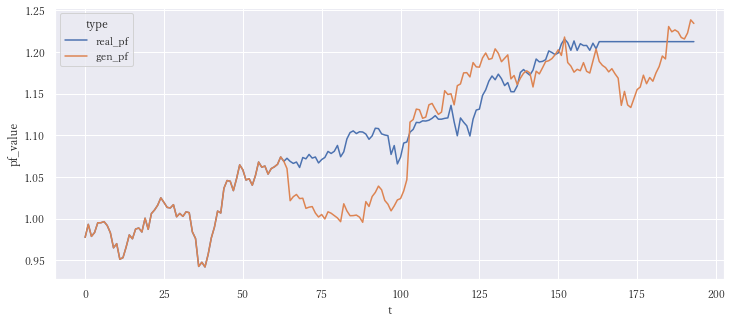

In [148]:
fig, ax = plt.subplots(figsize=(12, 5))
sns.lineplot(x='t', y='pf_value', hue='type', data=sim_data_pf, ax=ax)

In [154]:
# グラフの描画
def draw_plot_L1(sim_data):
    fig, ax = plt.subplots(figsize=(12, 5))

    ax.set_xlabel('日時')  # x軸ラベル
    ax.set_ylabel('株価')  # y軸ラベル
    title = "株価移動平均線"
    ax.set_title(title) # グラフタイトル

    ax.grid()            # 罫線
    #ax.set_xlim([-10, 10]) # x方向の描画範囲を指定
    #ax.set_ylim([0, 1])    # y方向の描画範囲を指定

    c1,c2 = "blue","red"      # 各プロットの色
    l1,l2 = "実際株価差異","予測株価差異"   # 各ラベル

    y1 = sim_data['real_pf']
    y2 = sim_data['gen_pf']

    ax.plot(y1, color=c1, label=l1)
    ax.plot(y2, color=c2, label=l2)

    ax.legend(loc=0)    # 凡例
    fig.tight_layout()  # レイアウトの設定
    
    fig.show()

C:\Users\es\anaconda3\envs\tf_r1\lib\site-packages\ipykernel_launcher.py:26: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


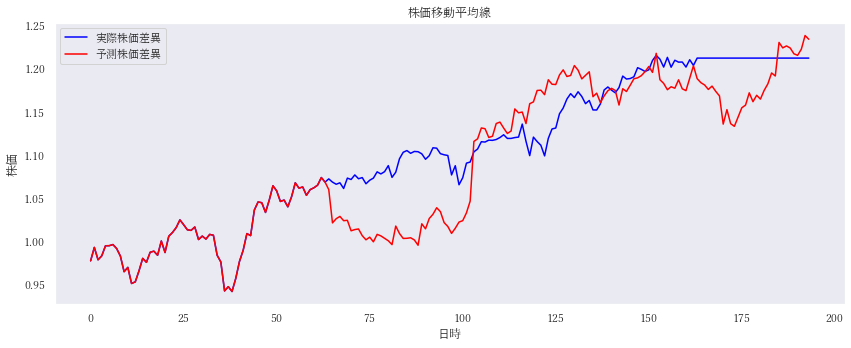

In [155]:
draw_plot_L1(sim_data)